##Import required Libraries

In [2]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
#Install module wget for the first time
!pip install wget
!pip install patool
import wget
import os, patoolib, numpy as np, math, scipy, re, pandas as pd,csv
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.corpus import stopwords, words
from nltk.util import ngrams
from numpy import hstack
from fnmatch import fnmatch
from itertools import product, combinations, zip_longest
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=dc9b83f594188f61ed7cf6917643797db5202e90b12ebb6f0474461ddac24f47
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 81kB 3.1MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [2]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# List data_batch files in the root.
filelist = drive.ListFile({'q': "'1k1k42wIe0fMC6l_bkIAZOiVELloEyHis' in parents and trashed=false"}).GetList() #https://drive.google.com/open?id=1k1k42wIe0fMC6l_bkIAZOiVELloEyHis
for file in filelist:
  print('title {}, id {}'.format(file['title'], file['id']))

     |████████████████████████████████| 993kB 1.4MB/s 
title Semantic_Matcher_Word_Embeddings_THESIS.ipynb, id 1qfaCbJMUiU_o15ILY0AsM3DeqFQtCrLS
title pyenchant.tar.gz, id 195xxlrclF2xZe8lWWeoQHXW9t4Rr9HWd
title GoogleNews-vectors-negative300.bin.gz, id 0B7XkCwpI5KDYNlNUTTlSS21pQmM


##WORD2VEC MODEL

In [0]:
# Downloading a file into COLAB from Google Drive that have been uploaded in Google Drive
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '0B7XkCwpI5KDYNlNUTTlSS21pQmM'   #pyenchant-2.0.0.tar.gz, id 195xxlrclF2xZe8lWWeoQHXW9t4Rr9HWd
downloaded = drive.CreateFile({'id': file_id})
#Storing the downloaded object into a File.
downloaded.GetContentFile('GoogleNews-vectors-negative300.bin.gz')

In [4]:
#To download Google's trained Word2Vec model.
#wget.download("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz")

#Unzipping the gunzip
patoolib.extract_archive("GoogleNews-vectors-negative300.bin.gz")

patool: Extracting GoogleNews-vectors-negative300.bin.gz ...
patool: running /usr/bin/7z e -o./Unpack_dymqkm2i -- GoogleNews-vectors-negative300.bin.gz
patool: ... GoogleNews-vectors-negative300.bin.gz extracted to `GoogleNews-vectors-negative300.bin'.


'GoogleNews-vectors-negative300.bin'

In [5]:
print(os.listdir('/content'))

#To load this pretrained model into memory,
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

['.config', 'adc.json', 'GoogleNews-vectors-negative300.bin.gz', 'GoogleNews-vectors-negative300.bin', 'sample_data']


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [6]:
#To get an embedding of a word for out of vocabulary


def generateOOVembeddings(vocab):
  st = vocab
  best_subset = ""
  all_words = {st[i:j + i] for j in range(2, len(st)) for i in range(len(st)- j + 1)}
  english_vocab = set(w.lower() for w in nltk.corpus.words.words())
  valid_eng_words = list(english_vocab.intersection(all_words))
  stop_words = set(stopwords.words('english'))
  valid_eng_words = ([w for w in valid_eng_words if w not in stop_words])
  #print(valid_eng_words)
  max = 0
  if(len(valid_eng_words) > 1):
    for L in range(0, len(valid_eng_words)+1):
        
        for subset in combinations(valid_eng_words, 2): 
            
            if((subset[0]+subset[1]) == st or (subset[1]+subset[0]) == st):
              best_subset = subset
        
  else:
    best_subset = valid_eng_words
  
  return(cal_Embeddings(best_subset))



0.080992356


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# To get the final embedding after character modelling
def cal_Embeddings(best_subset):
  addembedd = np.zeros(300)
  for var in best_subset:
    addembedd = addembedd + model.word_vec(var)
  return(addembedd/len(best_subset))



In [0]:
print(model.word_vec("city"))

In [0]:
def handle_flow_OOV(word):
  try:
    return model[word]
  except:
    return generateOOVembeddings(word)

##Similarity Measure of Embeddings

In [0]:
#Cosine distance similarity for out of vocabulary words
def cosine_distance_vectorized_method(fir1, fir2):  
  dot_prod = sum([x*y for (x,y) in zip(fir1, fir2)])
  vec1Len = math.sqrt(sum([x*x for x in fir1]))
  vec2Len = math.sqrt(sum([x*x for x in fir2]))
  return round(dot_prod / (vec1Len * vec2Len) * 100,2)
  #print(round(dot_prod / (vec1Len * vec2Len) * 100,2))

In [0]:
#Cosine distance similarity of words having embedding
def cosine_distance_wordembedding_method(s1, s2):
    vector_1 = np.mean([model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    #print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1 -cosine)*100,2),'%')
    return round((1 -cosine)*100,2)
     


In [0]:
def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()
    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = set([w for w in words if w not in stopword_set])
    return cleaned_words

##Load Dataset

In [0]:
#print(os.listdir('/content'))
items = os.listdir('/content')
for file in items:
  # To fetch all .tsv files
  if fnmatch(file, '*Event*'):
    #print (file)
    event = pd.read_csv(file , header=None, sep = '\t')
  elif fnmatch(file, '*Sub*'):
    subscription = pd.read_csv(file , header=None, sep = '\t')
  elif fnmatch(file, '*Relevance*'):
    relevance_gold = pd.read_csv(file , header=None, sep = '\t')
    

##Preprocessing Relevance Data

In [0]:
relevance_gold_event = []
relevance_gold_sub = []
for i in relevance_gold.itertuples():
  relevance_gold_event.append(i._2.strip("[]").split(','))
  relevance_gold_sub.append(i._1.strip("[]").split(','))
  
flat_list = [item for sublist in relevance_gold_sub for item in sublist]
print(flat_list)


## Create Gold Standard Dictionary

In [18]:
zipbObj = zip(flat_list, relevance_gold_event)
 
# Create a dictionary from zip object
gold_dict = dict(zipbObj)

print(gold_dict)

{'13-1': ['132-52', ' 132-53', ' 132-50', ' 132-51', ' 132-56', ' 132-57', ' 132-54', ' 132-55', ' 132-49', ' 132-48', ' 132-47', ' 132-11', ' 132-10', ' 132-13', ' 132-12', ' 132-40', ' 132-41', ' 132-42', ' 132-43', ' 132-44', ' 132-45', ' 132-46', ' 132-37', ' 132-36', ' 132-39', ' 132-38', ' 132-8', ' 132-7', ' 132-6', ' 132-5', ' 132-9', ' 132-29', ' 132-4', ' 132-25', ' 132-3', ' 132-26', ' 132-2', ' 132-27', ' 132-1', ' 132-28', ' 132-33', ' 132-32', ' 132-35', ' 132-34', ' 132-31', ' 132-30', ' 132-60', ' 132-65', ' 132-66', ' 132-67', ' 132-18', ' 132-68', ' 132-19', ' 132-61', ' 132-16', ' 132-62', ' 132-17', ' 132-63', ' 132-14', ' 132-64', ' 132-15', ' 132-24', ' 132-23', ' 132-22', ' 132-21', ' 132-59', ' 132-20', ' 132-58'], '63-1': ['5-30', ' 5-31', ' 5-32', ' 5-37', ' 5-38', ' 5-39', ' 5-33', ' 5-34', ' 5-35', ' 5-36', ' 5-20', ' 5-21', ' 5-28', ' 5-29', ' 5-26', ' 5-27', ' 5-24', ' 5-25', ' 5-22', ' 5-23', ' 5-67', ' 5-66', ' 5-68', ' 5-19', ' 5-63', ' 5-62', ' 5-65', 

## Event Types & Properties

In [0]:
# using a itertuples()  
event_types_prop = []
for i in event.itertuples(): 
    event_values = i._2.strip("{}").split(',')
    event_types_prop.append([i.split('=')[0] for i in event_values])
    #print(event_values)
    #print(event_values[::2])
    

##Subscription Types & Properties

In [0]:
# using a itertuples()  
subscription_types_prop = []
for i in subscription.itertuples(): 
    subscription_values = i._2.strip("{}").split(',')
    subscription_types_prop.append([i.split('~')[0] for i in subscription_values])

##Event Values

In [0]:
# using a itertuples()  
event_value = []
for i in event.itertuples(): 
    event_values = i._2.strip("{}").split(',')
    event_value.append([i.split('=')[1] for i in event_values])

##Subscription Values

In [0]:
# using a itertuples()  
subscription_value = []
for i in subscription.itertuples(): 
    subscription_values = i._2.strip("{}").split(',')
    sec = [i.split('~')[1] for i in subscription_values]
    subscription_value.append([i.split('=')[1] for i in sec])

##Event Matcher

In [29]:
from collections import defaultdict
word2vecDict = defaultdict(list)
#word2vecDict = {}
for i in event.itertuples():
    #print(i)
    event_types_prop = []
    event_value = []
    event_values = i._2.strip("{}").split(',')
    event_types_prop.append([i.split('=')[0] for i in event_values])
    event_value.append([i.split('=')[1] for i in event_values])
    
    for j in subscription.itertuples():
        subscription_types_prop = []
        subscription_value = []
        subscription_values = j._2.strip("{}").split(',')
        subscription_types_prop.append([i.split('~')[0] for i in subscription_values])
        sec = [i.split('~')[1] for i in subscription_values]
        subscription_value.append([i.split('=')[1] for i in sec])
        
        for slist in subscription_types_prop:
          for elist in event_types_prop:
            dist = 0
            for a, b in product(slist, elist):  
              try:
                cos_dist = cosine_distance_wordembedding_method(a,b)
                
                if(cos_dist > 65 ):
                  
                  dist = dist + cos_dist
              except:
                event_embedding = np.mean([handle_flow_OOV(word) for word in preprocess(b)],axis=0)
                try:
                  sub_embedding = np.array(model.word_vec(a))
                except:
                  sub_embedding = np.mean([handle_flow_OOV(word) for word in preprocess(a)],axis=0)
                cos_dist_mod = cosine_distance_vectorized_method(event_embedding, sub_embedding)
                #print(a,b,cos_dist_mod)
                if(cos_dist_mod > 25):
                  #print(a,b, cos_dist_mod)
                  dist = dist + cos_dist_mod
                  
        if(dist > 100):
          #print("================",dist)
          for slist in subscription_value:
            for elist in event_value:
              final_dist = 0
              for a,b in product(slist, elist):
                try:
                  cos_dist = cosine_distance_wordembedding_method(a,b)
                  if(cos_dist > 80 ):
                    #print(a,b, cos_dist)
                    final_dist = final_dist + cos_dist
                except:
                  #print("hello")
                  event_embedding = np.mean([handle_flow_OOV(word) for word in preprocess(b)],axis=0)
                  try:
                    sub_embedding = np.array(model.word_vec(a))
                  except:
                    sub_embedding = np.mean([handle_flow_OOV(word) for word in preprocess(a)],axis=0)
                  cos_dist_mod = cosine_distance_vectorized_method(event_embedding, sub_embedding)
                  if(cos_dist_mod > 25):
                    final_dist = final_dist + cos_dist_mod
              #print("==========", final_dist)
          if(final_dist >= 350):
            
            word2vecDict[j._1].append(i._1)
            
            
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

with open('word2vecDict', 'wb') as fp:
    pickle.dump(word2vecDict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


##Evaluation Metric

In [0]:
acc_each_record = 0
acc_each_rec = 0
prec_each_rec = 0
recall_each_rec = 0
f1_scr_each_rec = 0
  
for k in gold_dict.keys() & word2vecDict.keys():
    #print(gold_dict[k], ":", word2vecDict[k])
    a = gold_dict[k]
    b = word2vecDict[k]
    count = 0
    correct = 0
    print(len(a))
    print(len(b))
    a = list(map(str.strip, a))
    b = list(map(str.strip, b))
    tp_tn = sum(el in a for el in b)
    fn = get_false_negatives(a, b)
    fp = get_false_positives(a, b)
    acc_each_rec = acc_each_rec + (tp_tn/(tp_tn + fp + fn))
    prec_each_rec = prec_each_rec + (tp_tn/ (tp_tn + fp))
    recall_each_rec = recall_each_rec + (tp_tn/ (fn + tp_tn))
    f1_scr_each_rec = (2 * prec_each_rec * recall_each_rec)/(prec_each_rec + recall_each_rec)
    
    for i in range(len(a)):
      for j in range(len(b)):
        if(a[i].strip() == b[j]):
          correct+=1
    
    if (len(a) > len(b)):
      acc_each_record += correct/len(a)
    else:
      acc_each_record += correct/len(b)
    #print(sum(1 for x,y in zip(a,b) if x.strip() == y) / len(a))

print("Acurracy of the system is :", acc_each_rec/len(gold_dict.keys())*100)
print("Precision of the system is :", prec_each_rec/len(gold_dict.keys())*100)
print("Recall of the system is :", recall_each_rec/len(gold_dict.keys())*100)
print("F1 Score of the system is :", f1_scr_each_rec/len(gold_dict.keys()))

In [0]:

def get_false_negatives(actual, pred):
  cnt_fn = 0
  #len(list(set(list1) ^ set(list2)))
  for i in range(len(actual)):
    if(actual[i] not in pred):
      cnt_fn += 1
  return(cnt_fn)

def get_false_positives(actual, pred):
  cnt_fp = 0
  for i in range(len(pred)):
    if(pred[i] not in actual):
      cnt_fp += 1
  return(cnt_fp)

##Visualization

In [0]:
def display_closestwords_tsnescatterplot_word(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.savefig('word2vec_plot.png')
    plt.show()

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


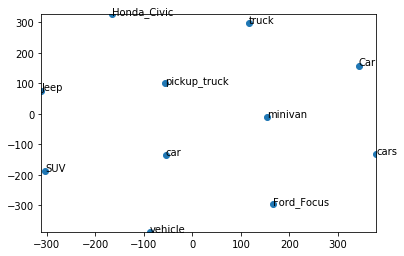

In [8]:
display_closestwords_tsnescatterplot_word(model, 'car')